# Introduction
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become cancer, with melanoma being the deadliest skin cancer. Its incidence has increased during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for skin cancer detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).

## Goal of the challenge
The goal of this challenge is to classify dermoscopic images of skin lesions among eight different diagnostic classes:
1. Melanoma
2. Melanocytic nevus
3. Basal cell carcinoma
4. Actinic keratosis
5. Benign keratosis
6. Dermatofibroma
7. Vascular lesion
8. Squamous cell carcinoma
In order to do that, you will extract features such as the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion (usually called the ABCD rule). After that, you will use machine learning algorithms to classify the images.

# Libraries

In [5]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

from skimage.io import imread
from skimage.segmentation import chan_vese, watershed
from skimage.draw import ellipse
from scipy import ndimage as ndi
from sklearn.cluster import KMeans
from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer

import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

2024-04-23 21:41:38.391865: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 21:41:38.391926: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 21:41:38.391969: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-23 21:41:38.402206: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            print(gpu)
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f'Error: {e}')

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')


In [3]:
train_directory = './Train/Train'
test_directory = './Test/Test'

# Data
You will use a data-set of 25331 dermoscopic images of skin lesions with, when available, their relative segmentation and metadata (age, sex and anatomical position). Data has already been randomly split into a training-validation set (75%) and a test set (25%). You only have the classification (made by clinicians) of the training-validation set. The goal of the project is to estimate the correct class of each dermoscopic image in the test set. **You can only use the data provided in this challenge**



### Data Load

In [4]:
# Load the data
train_metadata = pd.read_csv('metadataTrain.csv')
test_metadata = pd.read_csv('metadataTest.csv')


In [5]:
# # Load the images
# train_images_filenames = os.listdir(train_directory)
# test_images_filenames = os.listdir(test_directory)

# train_images_filenames = sorted(train_images_filenames)
# test_images_filenames = sorted(test_images_filenames)

# train_images = []
# train_masks = []
# test_images = []
# test_masks = []

# #Give me the code to put the images in the lists, the masks in the other lists, the mask are the images that finish with _seg.png
# for image in train_images_filenames:
#     if image.endswith('_seg.png'):
#         #Save the name whitout the _seg.png and the image
#         train_masks.append([image[:-8], imread(train_directory + '/' + image)])
#     else:
#         #Save the name without the .png and the image
#         train_images.append([image[:-4], imread(train_directory + '/' + image)])
        
# for image in test_images_filenames:
#     if image.endswith('_seg.png'):
#         #Save the name whitout the _seg.png and the image
#         test_masks.append([image[:-8], imread(test_directory + '/' + image)])
#     else:
#         #Save the name without the .png and the image
#         test_images.append([image[:-4], imread(test_directory + '/' + image)])



In [6]:
################BORRAR ESTA CELDA######
# Load the images
train_images_filenames = os.listdir(train_directory)
test_images_filenames = os.listdir(test_directory)

train_images_filenames = sorted(train_images_filenames)
test_images_filenames = sorted(test_images_filenames)

train_images = []
train_masks = []
test_images = []
test_masks = []

train_dataset = []
test_dataset = []

for image in train_images_filenames:
    if image.endswith('_seg.png'):
        # Save the name without the _seg.png and the image
        name = image[:-8]
        image_name = name + '.jpg'
        mask_image = imread(train_directory + '/' + image)
        image_image = imread(train_directory + '/' + image_name)
        
        train_dataset.append([image_image, mask_image])

        train_masks.append([name, mask_image])
        
    else: 
        name = image[:-4]
        image_image = imread(train_directory + '/' + image)

        train_images.append([name, image_image])
    
   
for image in test_images_filenames:
    if image.endswith('_seg.png'):
        # Save the name without the _seg.png and the image
        name = image[:-8]
        image_name = name + '.jpg'
        mask_image = imread(test_directory + '/' + image)
        image_image = imread(test_directory + '/' + image_name)

        test_dataset.append([image_image, mask_image])

        test_masks.append([name, mask_image])
        
    else:
        name = image[:-4]
        image_image = imread(test_directory + '/' + image)

        test_images.append([name, image_image])

In [7]:
# import random
# ######BORRAR ESTA CELDA#######

# # Load the images
# train_images_filenames = os.listdir(train_directory)
# test_images_filenames = os.listdir(test_directory)

# train_images_filenames = sorted(train_images_filenames)
# test_images_filenames = sorted(test_images_filenames)

# train_images = []
# train_masks = []
# test_images = []
# test_masks = []

# for image in train_images_filenames[:101]:
#     if image.endswith('_seg.png'):
#         # Save the name without the _seg.png and the image
#         train_masks.append([image[:-8], imread(train_directory + '/' + image)])
#     else:
#         # Save the name without the .png and the image
#         train_images.append([image[:-4], imread(train_directory + '/' + image)])

# for image in test_images_filenames[:101]:
#     if image.endswith('_seg.png'):
#         # Save the name without the _seg.png and the image
#         test_masks.append([image[:-8], imread(test_directory + '/' + image)])
#     else:
#         # Save the name without the .png and the image
#         test_images.append([image[:-4], imread(test_directory + '/' + image)])


# train_images_sample = random.sample(range(4000, len(train_images_filenames)), 400)
# test_images_sample = random.sample(range(4000, len(test_images_filenames)), 400)

# for i in train_images_sample:
#     image = train_images_filenames[i]
#     if image.endswith('_seg.png'):
#         # Save the name without the _seg.png and the image
#         train_masks.append([image[:-8], imread(train_directory + '/' + image)])
#     else:
#         # Save the name without the .png and the image
#         train_images.append([image[:-4], imread(train_directory + '/' + image)])

# for i in test_images_sample:
#     image = test_images_filenames[i]
#     if image.endswith('_seg.png'):
#         # Save the name without the _seg.png and the image
#         test_masks.append([image[:-8], imread(test_directory + '/' + image)])
#     else:
#         # Save the name without the .png and the image
#         test_images.append([image[:-4], imread(test_directory + '/' + image)])

## Data Analysis

### Text Features

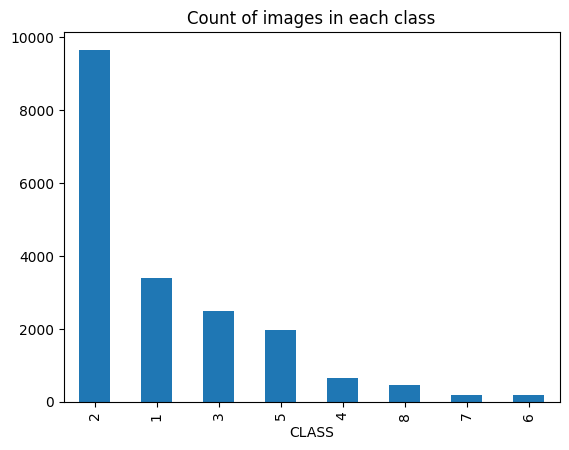

In [8]:
# Value counts of the classes
train_metadata['CLASS'].value_counts().plot(kind='bar')
plt.title('Count of images in each class')
plt.show()

In [9]:
train_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18998 entries, 0 to 18997
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        18998 non-null  object 
 1   CLASS     18998 non-null  int64  
 2   SEX       18714 non-null  object 
 3   AGE       18674 non-null  float64
 4   POSITION  17028 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 742.2+ KB


In [10]:
# Description of the data 
train_metadata.describe(include='object')

ID    SEX        POSITION
count          18998  18714           17028
unique         18998      2               8
top     ISIC_0028766   male  anterior torso
freq               1   9978            5194

In [11]:
train_metadata.describe()

CLASS           AGE
count  18998.000000  18674.000000
mean       2.568323     53.991914
std        1.532728     18.094209
min        1.000000      0.000000
25%        2.000000     40.000000
50%        2.000000     55.000000
75%        3.000000     70.000000
max        8.000000     85.000000

In [12]:
test_metadata.describe(include='object')

ID   SEX        POSITION
count           6333  6233            5672
unique          6333     2               8
top     ISIC_0055289  male  anterior torso
freq               1  3308            1721

In [13]:
test_metadata.describe()

AGE
count  6220.000000
mean     54.138264
std      18.241916
min       0.000000
25%      40.000000
50%      55.000000
75%      70.000000
max      85.000000

### Image Features

In [14]:
#Count images loaded
print(f'Number of training images: {len(train_images)}')
print(f'Number of training masks: {len(train_masks)}')

print(f'Number of testing images: {len(test_images)}')
print(f'Number of testing masks: {len(test_masks)}')
    

Number of training images: 18998
Number of training masks: 1945
Number of testing images: 6333
Number of testing masks: 648


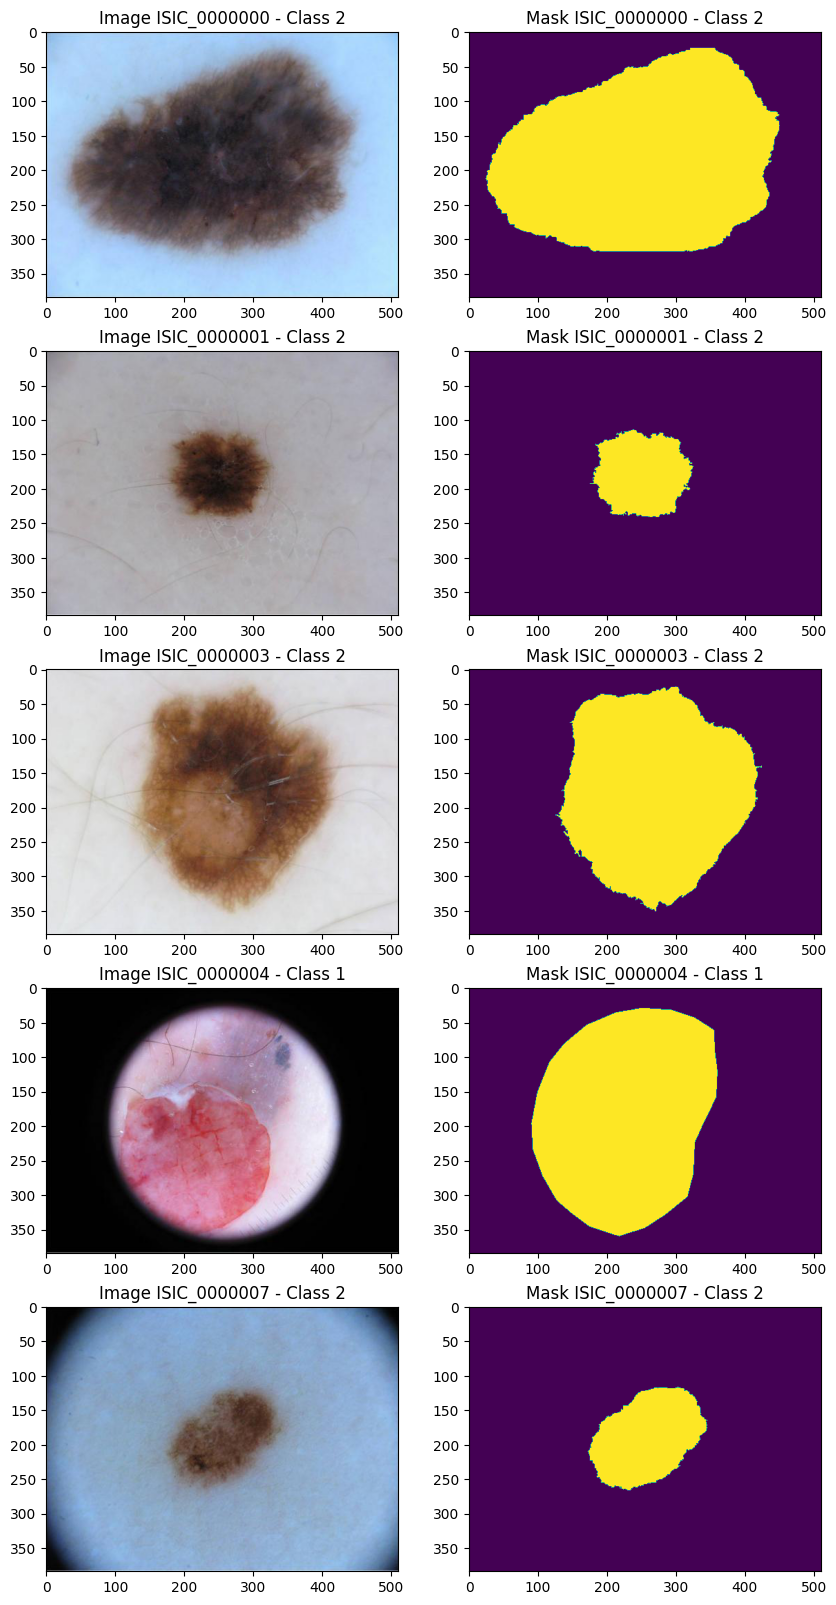

In [15]:
# Display a few images with the corresponding masks the corresponding masks have the same id as the image and their class

# Display the first 5 images
fig, ax = plt.subplots(5, 2, figsize=(10, 20))

#get the first 5 masks
first_5_masks = [mask[0] for mask in train_masks[:5]]

j = 0
for i in first_5_masks:
    #Get the image
    image = next((item for item in train_images if item[0] == i), None)
    #Get the mask
    mask = next((item for item in train_masks if item[0] == i), None)
    
    #Get the class
    class_ = train_metadata[train_metadata['ID'] == i]['CLASS'].values[0]
    
    #Plot the image
    ax[j, 0].imshow(image[1])
    ax[j, 0].set_title(f'Image { image[0] } - Class {class_}')
    
    #Plot the mask
    ax[j, 1].imshow(mask[1])
    ax[j, 1].set_title(f'Mask {mask[0]} - Class {class_}')

    j += 1


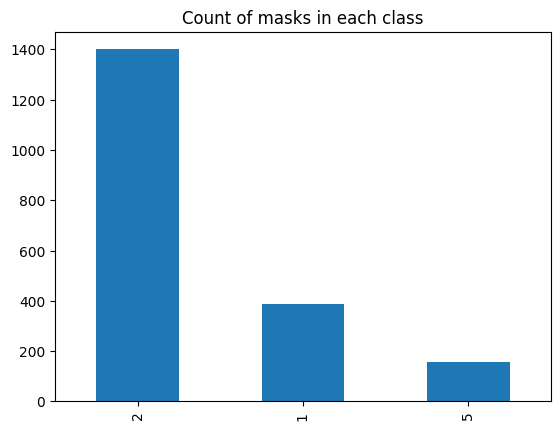

In [16]:
# Value counts of the classes in the masks

#Get the classes of the masks
masks_classes = [train_metadata[train_metadata['ID'] == mask[0]]['CLASS'].values[0] for mask in train_masks]

#Plot the classes
pd.Series(masks_classes).value_counts().plot(kind='bar')
plt.title('Count of masks in each class')
plt.show()


# Image Processing
You can use all features you'd like. A list of references describing very well-known features can be found at the end of this page but you can find many more articles in the Literature. You can use Pubmed, Google Scholar or simply Google to look for them.


## Image Preprocessing

## Segmentation

### U net Segmentation

In [7]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]


In [18]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   
   # Reshape the mask to add a channel dimension
   input_mask = tf.reshape(input_mask, (input_mask.shape[0], input_mask.shape[1], 1))
   # Resize the mask
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   # Reshape the mask back to remove the channel dimension
   #input_mask = tf.squeeze(input_mask, axis=-1)
   return input_image, input_mask
   

def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)

       # Reshape the mask to add a channel dimension
       input_mask = tf.reshape(input_mask, (input_mask.shape[0], input_mask.shape[1], 1))
       input_mask = tf.image.flip_left_right(input_mask)
       #input_mask = tf.squeeze(input_mask, axis=-1)
   return input_image, input_mask

def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

In [19]:
def load_image_train(input_image, input_mask):
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask

def load_image_test(input_image, input_mask):
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask

In [20]:
train_dataset = [load_image_train(image[0], image[1]) for image in train_dataset]
test_dataset = [load_image_test(image[0], image[1]) for image in test_dataset]

2024-03-30 19:53:03.451281: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 36465 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:27:00.0, compute capability: 8.0
2024-03-30 19:53:03.453140: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 36469 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:a3:00.0, compute capability: 8.0
2024-03-30 19:53:03.455179: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38374 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0
2024-03-30 19:53:03.605722: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [21]:
#convert to tensor
aux_train_images = tf.convert_to_tensor([image[0] for image in train_dataset])
aux_train_masks = tf.convert_to_tensor([image[1]/255 for image in train_dataset])


aux_test_images = tf.convert_to_tensor([image[0] for image in test_dataset])
aux_test_masks = tf.convert_to_tensor([image[1]/255 for image in test_dataset])

In [22]:
#put in the same dataset
train_dataset = tf.data.Dataset.from_tensor_slices((aux_train_images, aux_train_masks))

test_dataset = tf.data.Dataset.from_tensor_slices((aux_test_images, aux_test_masks))


In [23]:
BATCH_SIZE = 64
BUFFER_SIZE = 100
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(300).batch(BATCH_SIZE)
test_batches = test_dataset.skip(300).take(348).batch(BATCH_SIZE)

2024-03-30 19:53:32.492117: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


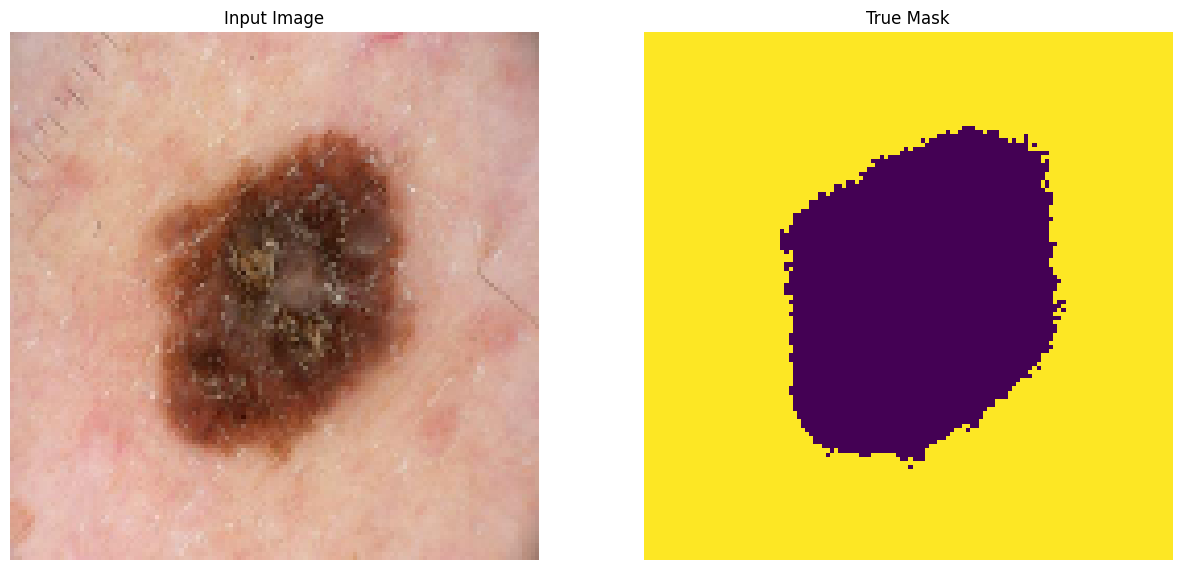

In [25]:
def display(display_list):
 plt.figure(figsize=(15, 15))
 title = ["Input Image", "True Mask", "Predicted Mask"]
 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()
sample_batch = next(iter(train_batches))
random_index = 0
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [8]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [27]:
def build_unet_model():
    # inputs
    inputs = layers.Input(shape=(128,128,3))
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # outputs
    outputs = layers.Conv2D(2, 1, padding="same", activation = "softmax")(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model

In [28]:
unet_model = build_unet_model()

In [29]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics=['accuracy'])

In [30]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            print(gpu)
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f'Error: {e}')

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')


In [31]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]

In [33]:
NUM_EPOCHS = 30
TRAIN_LENGTH = len(train_images)
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
TEST_LENTH = len(test_images)
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)

Epoch 1/30


2024-03-30 19:53:57.498512: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-Net/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-30 19:53:57.884521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-03-30 19:53:57.996102: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-30 19:54:06.277453: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fca640017b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-30 19:54:06.277488: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-03-30 19:54:06.277493: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100-PCIE-40GB, Comp

296/296 [==============================] - 201s 373ms/step - loss: 1.0284 - accuracy: 0.7493 - val_loss: 0.4670 - val_accuracy: 0.6783
Epoch 2/30


2024-03-30 19:57:16.353181: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2327931746610950387
2024-03-30 19:57:16.353221: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8879269963603849349
2024-03-30 19:57:16.353250: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12452231924220451565


296/296 [==============================] - 70s 237ms/step - loss: 0.3742 - accuracy: 0.7552
Epoch 3/30
296/296 [==============================] - 70s 238ms/step - loss: 0.3510 - accuracy: 0.7530
Epoch 4/30
296/296 [==============================] - 70s 237ms/step - loss: 0.3439 - accuracy: 0.7548
Epoch 5/30
296/296 [==============================] - 70s 236ms/step - loss: 0.3369 - accuracy: 0.7564
Epoch 6/30
296/296 [==============================] - 70s 236ms/step - loss: 0.3109 - accuracy: 0.7512
Epoch 7/30
296/296 [==============================] - 70s 236ms/step - loss: 0.2718 - accuracy: 0.7532
Epoch 8/30
296/296 [==============================] - 70s 236ms/step - loss: 0.2488 - accuracy: 0.7529
Epoch 9/30
296/296 [==============================] - 70s 236ms/step - loss: 0.2352 - accuracy: 0.7582
Epoch 10/30
296/296 [==============================] - 70s 236ms/step - loss: 0.2237 - accuracy: 0.7564
Epoch 11/30
296/296 [==============================] - 70s 236ms/step - loss: 0.217

In [34]:
#save the model 
unet_model.save('unet_model.h5')

/home/infres/jrios-23/miniconda3/envs/venv_cuda/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
def create_mask(pred_mask):
 pred_mask = tf.argmax(pred_mask, axis=-1)
 pred_mask = pred_mask[..., tf.newaxis]
 return pred_mask[0]

def show_predictions(dataset=None, num=1):
 if dataset:
   for image, mask in dataset.take(num):
     pred_mask = unet_model.predict(image)
     display([image[0], mask[0], create_mask(pred_mask)])
 else:
   display([sample_image, sample_mask,
            create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])
count = 0
for i in test_batches:
   count +=1
print("number of batches:", count)

NameError: name 'test_batches' is not defined

In [ ]:
test_batches

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>

2/2 [==============================] - 6s 8ms/step


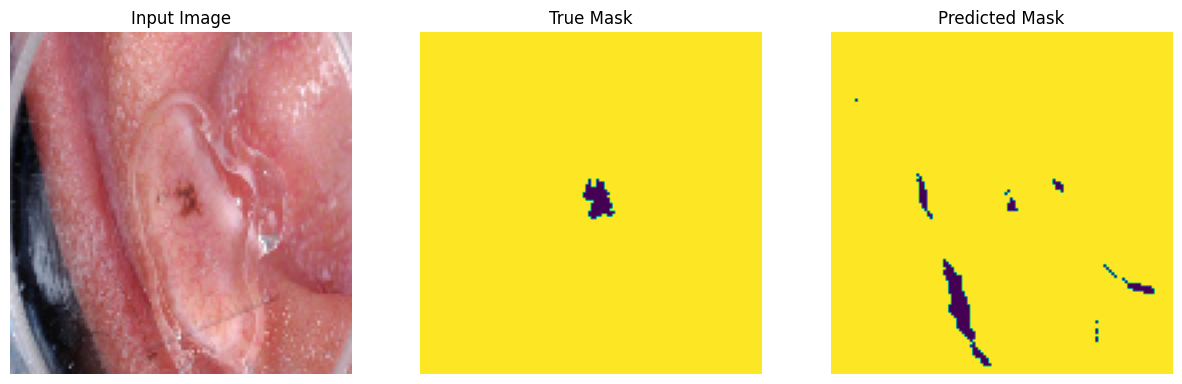

2/2 [==============================] - 0s 32ms/step


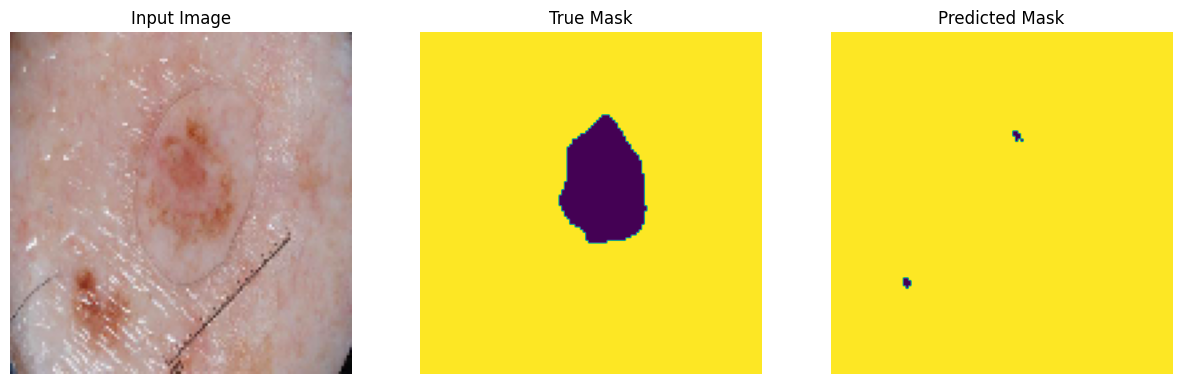

2/2 [==============================] - 0s 32ms/step


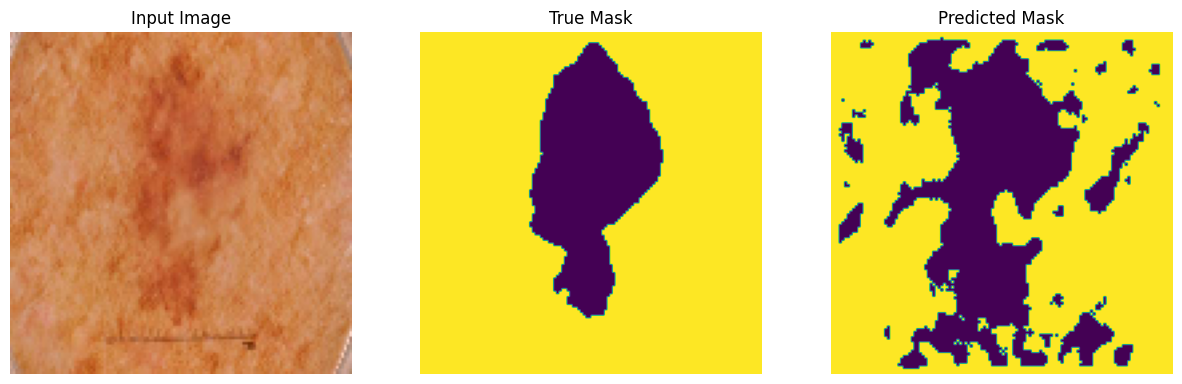

In [ ]:
show_predictions(test_batches, 3)

In [ ]:
train_images[0][1].shape

(384, 511, 3)

## Upload Model

In [17]:
# Upload the model
unet_model = tf.keras.models.load_model('unet_model.h5')

2024-04-23 10:28:36.242514: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31181 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:27:00.0, compute capability: 8.0
2024-04-23 10:28:36.244348: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 36469 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:a3:00.0, compute capability: 8.0
2024-04-23 10:28:36.246393: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 17991 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [18]:
def resize_test(input_image):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_image = tf.expand_dims(input_image, axis=0)
   return input_image
   

def normalize_test(input_image):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   return input_image

def load_image_nomask_test(input_image):
   input_image = resize_test(input_image)
   input_image = normalize_test(input_image)
   return input_image

#Now try to predict the masks of the test images
def predict_mask(image):
   image_aux = load_image_nomask_test(image)
   
   pred_mask = unet_model.predict(image_aux)
   
   return pred_mask

train_images = [[image[0], image[1], predict_mask(image[1])] for image in train_images]
test_images = [[image[0], image[1], predict_mask(image[1])] for image in test_images]

# def image_mask(image):
#    return [image[0], image[1], predict_mask(image[1])]

# def joblib_predict_mask(images):
#     return Parallel(n_jobs=-2, verbose=1)(delayed(image_mask)(image) for image in images)

# train_images = joblib_predict_mask(train_images)
# test_images = joblib_predict_mask(test_images)

2024-04-23 10:28:40.604544: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-04-23 10:28:41.543010: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 35ms/step


In [19]:
def create_mask(pred_mask):
 pred_mask = tf.argmax(pred_mask, axis=-1)
 pred_mask = pred_mask[..., tf.newaxis]
 return pred_mask[0]

def resize_mask(image, mask):
   mask = tf.image.resize(mask, (image.shape[0],image.shape[1]), method="nearest")
   #delete channel dimension
   mask = tf.squeeze(mask, axis=-1)
   return mask


def postprocessing_mask(image, pred_mask):
   with tf.device('/CPU:0'):
      pred_mask = create_mask(pred_mask)
      pred_mask = resize_mask(image, pred_mask)
      pred_mask = tf.where(pred_mask == 0, 1, 0)
   return pred_mask.numpy().astype(np.uint8)


train_images = [[image[0], image[1],postprocessing_mask(image[1],image[2])] for image in train_images]
test_images = [[image[0], image[1], postprocessing_mask(image[1],image[2])] for image in test_images]
   

In [20]:
#save the mask with the image[0]+mask.png

def save_mask(image, folder):
    cv2.imwrite(f'./{folder}/{image[0]}_mask.png', image[2])
    
def joblib_save_mask(images, folder):
    return Parallel(n_jobs=-2, verbose=1)(delayed(save_mask)(image, folder) for image in images)

joblib_save_mask(train_images, 'masks_train')
joblib_save_mask(test_images, 'masks_test')

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 63 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-2)]: Done 522 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-2)]: Done 1222 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-2)]: Done 2122 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-2)]: Done 3222 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-2)]: Done 4522 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-2)]: Done 6022 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-2)]: Done 7722 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-2)]: Done 9622 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-2)]: Done 11722 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done 14022 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 16522 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-2)]: Done 18873 out of 18998 | elapsed:  1.4min remaining:    0.6s
[Parallel(n_jobs=-2)]: Done 18998 out of 18998 | elapsed:  1.4min finished
[Paral

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

### Termina UNET


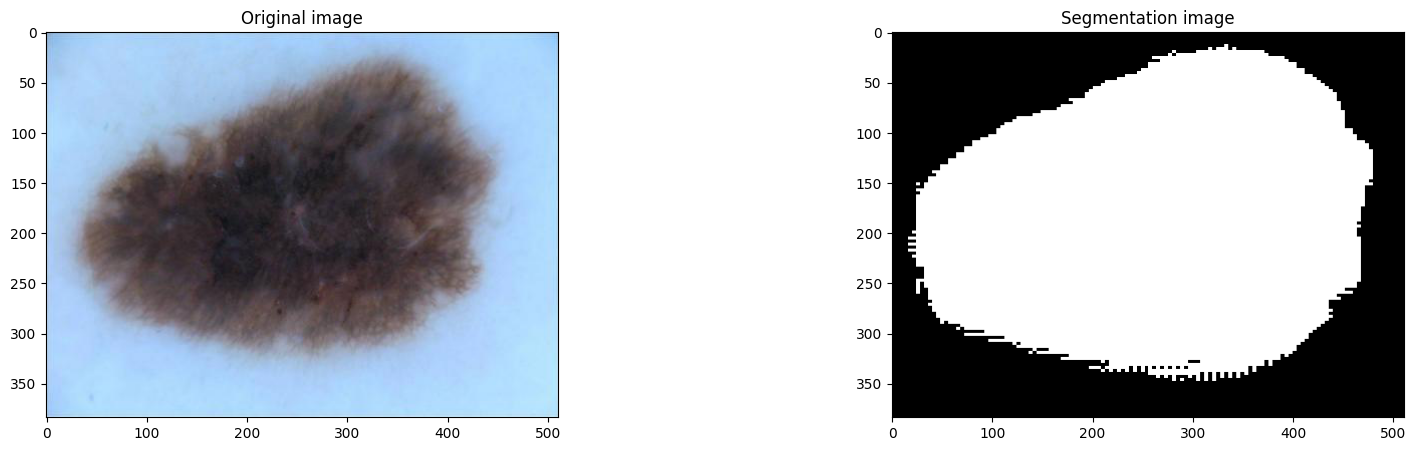

In [21]:
#plot the original image, the gray, the blur and the segmentation
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].imshow(train_images[0][1])
ax[0].set_title('Original image')

ax[1].imshow(train_images[0][2], cmap='gray')
ax[1].set_title('Segmentation image')


plt.show()

## Image Postprocessing

In [22]:
#morphological operations
def get_morphological_operations(image):
    # Convert the image to the appropriate data type
    image = image.astype(np.uint8)

    # Morphological closing
    kernel = np.ones((55, 55), np.uint8)
    closing = cv2.morphologyEx(image, cv2.MORPH_DILATE, kernel)

    return closing

#Apply the morphological operations to the images and different segmentations

train_images =  [
                    [   image[0], image[1], image[2],
                        get_morphological_operations(image[2]),
                    ] 
                  for image in train_images]

test_images =   [
                    [
                        image[0], image[1], image[2],
                        get_morphological_operations(image[2])
                    ] 
                  for image in test_images]

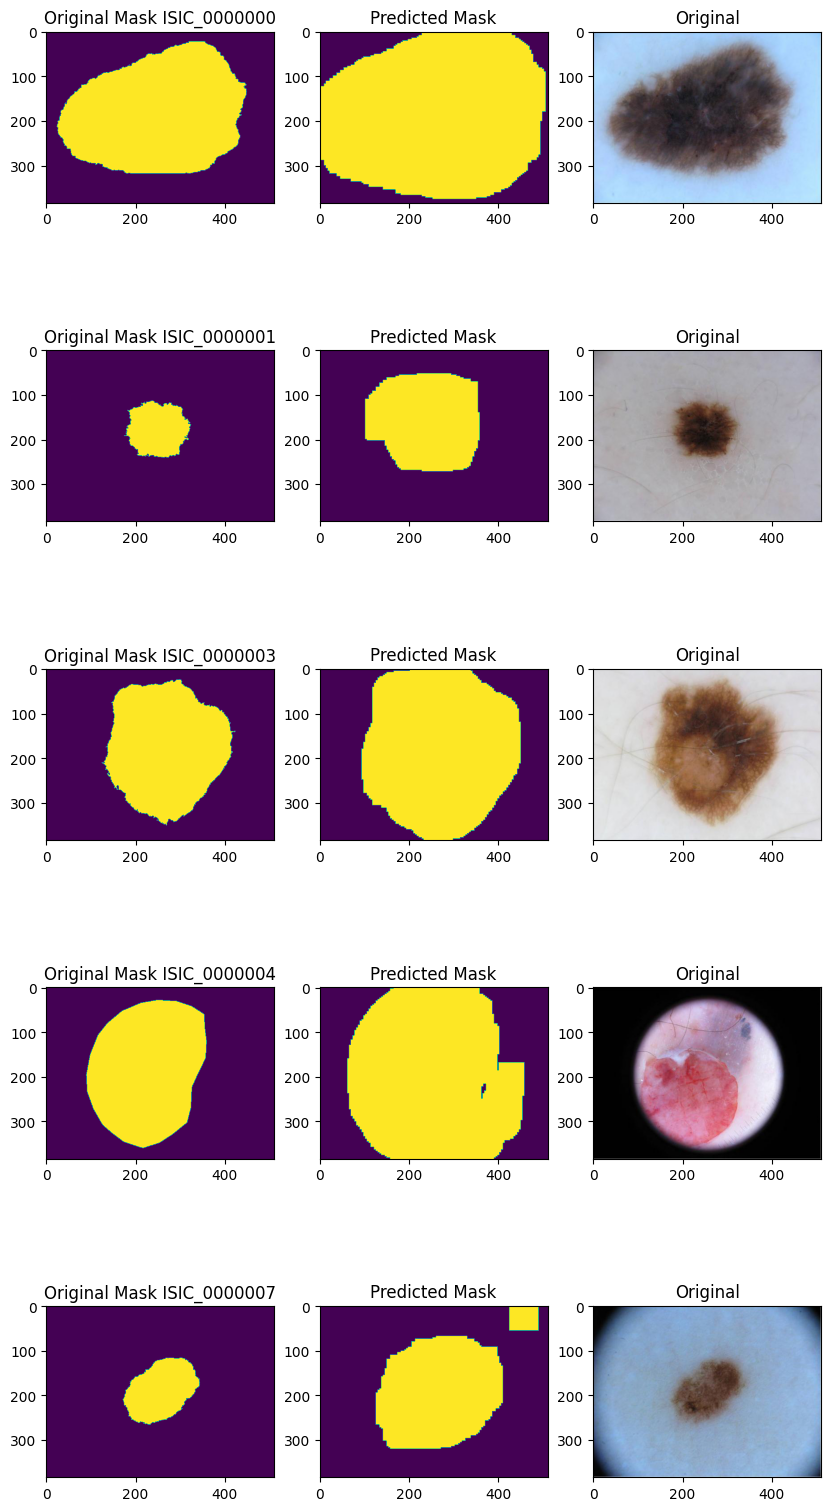

In [23]:
#comparison of the original masks and the segmented ones
fig, ax = plt.subplots(5, 3, figsize=(10, 20))

#get the first 5 masks
first_5_masks = [mask[0] for mask in train_masks[:5]]

j = 0

for i in first_5_masks:
    #Get the image
    image = next((item for item in train_images if item[0] == i), None)
    #Get the mask
    mask = next((item for item in train_masks if item[0] == i), None)
    
    #Get the class
    class_ = train_metadata[train_metadata['ID'] == i]['CLASS'].values[0]
    
    #Plot the original mask
    ax[j, 0].imshow(mask[1])
    ax[j, 0].set_title(f'Original Mask {mask[0]}')
    
    #Plot the segmented mask
    ax[j, 1].imshow(image[3])
    ax[j, 1].set_title(f'Predicted Mask')

    #Plot the segmented mask
    ax[j, 2].imshow(image[1])
    ax[j, 2].set_title(f'Original')

    j += 1

plt.show()

## Dice Coefficient

In [24]:
#GET THE IMAGE THAT ARE IN MASK AND NOT IN IMAGES
mask_images = [mask[0] for mask in train_masks]
images = [image[0] for image in train_images]

mask_images = set(mask_images)
images = set(images)

no_correspondance = mask_images - images

no_correspondance


set()

In [25]:
#Dice score between the original masks and the segmented ones
def dice_score(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    return 2 * intersection.sum() / (mask1.sum() + mask2.sum())

dice_scores = []
dice_scores_chan_vese = []
dice_scores_watershed = []
dice_scores_thresholding = []
dice_scores_kmeans = []



for mask in train_masks:
    
        #The image in the original mask
        mask_original = mask[1]
        mask_original[mask_original == 255] = 1
        #The segmented mask
        mask_segmented = next((item for item in train_images if item[0] == mask[0]), None)
        
    
        dice_scores.append(dice_score(mask_original, mask_segmented[2]))

for mask in test_masks:
    #The image in the original mask
    mask_original = mask[1]
    mask_original[mask_original == 255] = 1
    #The segmented mask
    mask_segmented = next((item for item in test_images if item[0] == mask[0]), None)

    dice_scores.append(dice_score(mask_original, mask_segmented[2]))

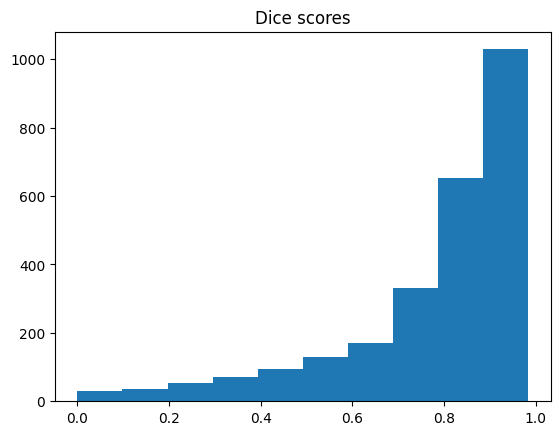

In [26]:
#Plot the dice scores
plt.hist(dice_scores)
plt.title('Dice scores')

plt.show()

In [27]:
#Mean of the dice scores
print(f'Mean Dice score: {np.mean(dice_scores)}')

#Percentage of the dice scores greater than 0.8
print(f'Percentage of Dice scores greater than 0.8: {np.mean(np.array(dice_scores) > 0.8)}')


Mean Dice score: 0.7769188378097417
Percentage of Dice scores greater than 0.8: 0.626687234863093


In [28]:
#Get the amount of dice score = 0
print(f'Amount of dice score < 0.2: {np.sum(np.array(dice_scores) < 0.2)}')

#Get the amount of dice score = 1
print(f'Amount of dice score > 0.7: {np.sum(np.array(dice_scores) > 0.7)}')


Amount of dice score < 0.2: 69
Amount of dice score > 0.7: 1977


## Border Detection

In [29]:
#Find contours in the segmented masks
def get_contours(image):
    contours, _ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

train_images =  [[image[0], image[1], image[2], get_contours(image[2])] for image in train_images]
test_images =   [[image[0], image[1], image[2], get_contours(image[2])] for image in test_images]

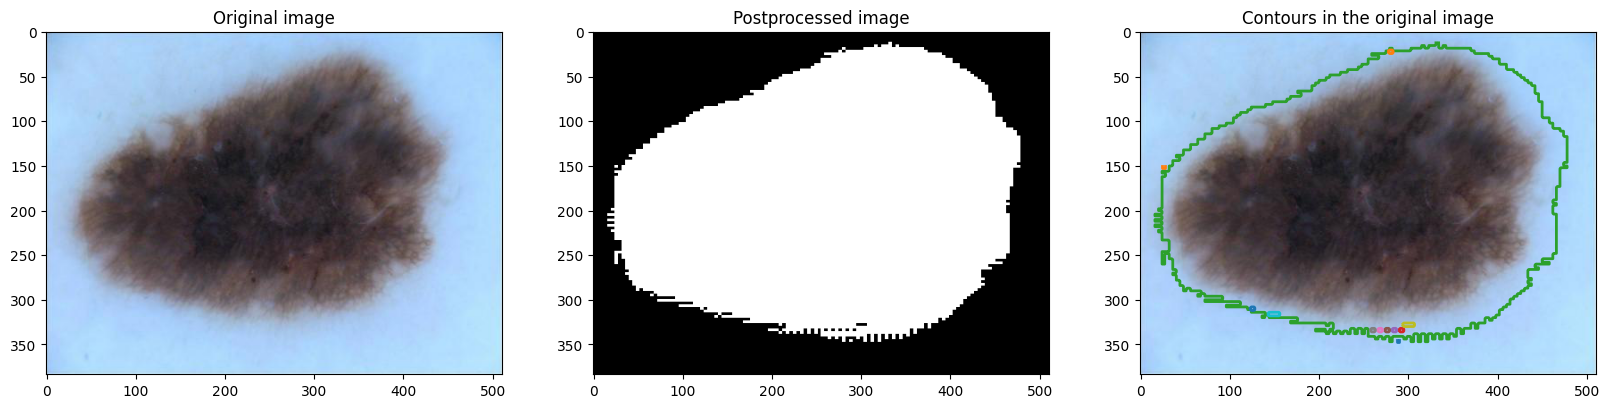

In [30]:
#Plot the original ilage, the postprocessed, and the contours in the original one
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].imshow(train_images[0][1])
ax[0].set_title('Original image')

ax[1].imshow(train_images[0][2], cmap='gray')
ax[1].set_title('Postprocessed image')

ax[2].imshow(train_images[0][1])
ax[2].set_title('Contours in the original image')
for contour in train_images[0][3]:
    ax[2].plot(contour[:, 0, 0], contour[:, 0, 1], linewidth=2)

plt.show()

## Feature Extraction

The ABCD rule is a method to evaluate the risk of a skin lesion being a melanoma. It is based on the following features:
- **A**symmetry
- **B**order irregularity
- **C**olour
- **D**imension

In [31]:
train_images_features = []
test_images_features = []

### Asymmetry




In [37]:
# Function to calculate the distance between two points
def distance(p1, p2):
    return np.sqrt((p1[0][0] - p2[0][0])**2 + (p1[0][1] - p2[0][1])**2)

def longest_diagonal(lesion_boundary):

    # Initialize the maximum diagonal length and coordinates
    max_diag_length = 0
    max_diag_coords = (0, 0, 0, 0)

    # Find the longest diagonal by checking distances between all pairs of points
    for i in range(len(lesion_boundary)):
        for j in range(i+1, len(lesion_boundary)):
            diag_length = distance(lesion_boundary[i], lesion_boundary[j])
            if diag_length > max_diag_length:
                max_diag_length = diag_length
                max_diag_coords = lesion_boundary[i], lesion_boundary[j]

    return max_diag_coords

def calculate_assymetry_features(image):
    try:
        # Assuming the largest contour corresponds to the lesion boundary
        # This will be a list of (row, col) coordinates of the boundary pixels
        
        lesion_boundary = max(image[3], key=len)

        # Find the longest diagonal of the lesion
        max_diag_coords = longest_diagonal(lesion_boundary)
        
        # Define the number of perpendicular lines
        N = 10
        T = len(lesion_boundary)
        P = T / N
        
        # Calculate the distances from points on the diagonal to the lesion boundary
        diagonal_length = np.linalg.norm(max_diag_coords[0] - max_diag_coords[1])
        step_size = diagonal_length / N
        distances = []
        for i in range(N):
            point_on_diagonal = max_diag_coords[0] + (max_diag_coords[1] - max_diag_coords[0]) * (i * step_size / diagonal_length)
            perp_distances = [np.linalg.norm(point_on_diagonal - contour_point) for contour_point in lesion_boundary]
            distances.append((min(perp_distances), max(perp_distances)))
        
        # Compute the features
        ratios = [d[0] / d[1] if d[1] != 0 else 0 for d in distances]
        std_dev = np.std(ratios)
        
        assymetry_features = { 'std_dev': std_dev, 'ratios': ratios}
    
        #Assymetry features in that format
        assymetry_features = { 'std_dev': std_dev }
        assymetry_features.update({ f'ratio_{i}': val for i, val in enumerate(ratios) })
        
        # Return the features in a dictionary
        return assymetry_features
    except Exception as e:
        print(image[0])
        print('Error')
        print(e)
        return None


### Border Irregularity

In [32]:
def calculate_border_irregularity_features(border):
    """
    Calculate border irregularity features based on the inflection points and vector product descriptors.
    
    :param border: A numpy array of the contour points of the lesion border.
    :return: A dictionary with counts of peaks, valleys, and straight lines for both small and large irregularities.
    """
    border = border[:, 0, :]
        
    # Initialize the counts for small irregularities
    small_irregularities = {'peaks': 0, 'valleys': 0, 'straight_lines': 0}

    # Initialize the counts for large irregularities
    large_irregularities = {'peaks': 0, 'valleys': 0, 'straight_lines': 0}

    # Inflection point descriptor parameters
    T1 = 2
    T2 = -2

    # Calculate small irregularities based on inflection points
    for i in range(1, len(border) - 1):
        # Get the neighbors
        left_neighbor = border[i - 1]
        right_neighbor = border[i + 1]

        # Calculate the weights (y-axis difference)
        Wl = left_neighbor[1] - border[i][1]
        Wr = right_neighbor[1] - border[i][1]

        # Sum the weights
        S = Wl + Wr

        # Determine if it's a peak, valley, or straight line based on the weight sum
        if S > T1:
            small_irregularities['peaks'] += 1
        elif S < T2:
            small_irregularities['valleys'] += 1
        else:
            small_irregularities['straight_lines'] += 1

    # Function to calculate vector product V for three points p1, p2, p3
    def vector_product(p1, p2, p3):
        (x1, y1), (x2, y2), (x3, y3) = p1, p2, p3
        return (x2 - x1) * (y3 - y1) - (y2 - y1) * (x3 - x1)

    # Calculate large irregularities based on vector products
    for i in range(15,len(border)-15):
        # Ensure circular indexing at the borders
        p1 = border[i - 15]
        p2 = border[i]
        p3 = border[(i + 15)]

        # Calculate the vector product
        V = vector_product(p1, p2, p3)

        # Determine if it's a peak, valley, or straight line based on vector product
        if V > 0:
            large_irregularities['peaks'] += 1
        elif V < 0:
            large_irregularities['valleys'] += 1
        else:
            large_irregularities['straight_lines'] += 1

    

    # Return the calculated features in a dictionary
    return small_irregularities, large_irregularities


### Colour

In [33]:
def calculate_color_features(image):
    """
    Calculate color features for an image in the RGB color space.
    
    :param image: RGB image as a numpy array.
    :return: A dictionary with the mean, variance, and standard deviation for each RGB channel.
    """
    color_features = {}
    # Split the image into R, G, and B channels
    R, G, B = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    
    # Calculate the mean, variance, and standard deviation for each channel
    color_features['mean_R'] = np.mean(R)
    color_features['mean_G'] = np.mean(G)
    color_features['mean_B'] = np.mean(B)
    
    color_features['variance_R'] = np.var(R)
    color_features['variance_G'] = np.var(G)
    color_features['variance_B'] = np.var(B)
    
    color_features['std_dev_R'] = np.std(R)
    color_features['std_dev_G'] = np.std(G)
    color_features['std_dev_B'] = np.std(B)
    
    return color_features

### Dimension

In [34]:
def calculate_fractal_dimension(image):
    """
    Calculate the fractal dimension of an image using the box-counting method.
    
    :param image: Mask image as a numpy array.
    :return: The fractal dimension D of the image.
    """

    # Box-counting implementation
    def boxcount(binary_image, k):

        S = np.add.reduceat(
                np.add.reduceat(binary_image, 
                                np.arange(0, binary_image.shape[0], k), axis=0),
                np.arange(0, binary_image.shape[1], k), axis=1)
        
        return len(np.where(S > 0)[0])

    # Fractal dimension calculation
    p = min(image.shape)
    n = 2**np.floor(np.log(p)/np.log(2))
    n = int(np.log(n)/np.log(2))
    sizes = 2**np.arange(n, 1, -1)
    counts = []
    for size in sizes:
        counts.append(boxcount(image, size))

    if len(sizes) > 0 and len(counts) > 0:
        coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    else:
        coeffs = np.array([0, 0])

    return -coeffs[0] if len(coeffs) > 0 else 0


In [35]:
def calculate_texture_features(image):
    """
    Calculate the texture features of an image.
    
    :param image_path: mask image.
    :return: A dictionary with the calculated texture features.
    """
    
    # Calculate the fractal dimension of the whole image
    D = calculate_fractal_dimension(image)

    # Calculate the fractal dimension of 16 parts of the image
    rows, cols = image.shape
    step_r, step_c = rows // 4, cols // 4
    D_parts = []
    for i in range(0, rows, step_r):
        for j in range(0, cols, step_c):
            part = image[i:i+step_r, j:j+step_c]
            
            D_parts.append(calculate_fractal_dimension(part))
    
    # Calculate the image-based fractal dimension D2
    D2 = np.mean(D_parts) + 1
    
    # Create a dictionary to store the texture features
    texture_features = {
        'fractal_dimension_total': D,
        'fractal_dimensions_parts': D_parts,
        'fractal_dimension_D2': D2
    }

    # Return the features in a dictionary
    texture_features = { 'fractal_dimension_total': D }
    texture_features.update({ f'fractal_dimension_part_{i}': val for i, val in enumerate(D_parts) })
    texture_features['fractal_dimension_D2'] = D2
    
    return texture_features

### Add features

In [36]:
def get_features(image):
    
    if len(image[3]) > 0:
        id = {'ID':image[0]}
        assymetry_features = calculate_assymetry_features(image)
        small_irregularities, large_irregularities = calculate_border_irregularity_features(image[3][0])
        color_features = calculate_color_features(image[1])
        #texture_features = calculate_texture_features(image[3])

        # Return the features in a dictionary
        #return {**id, **assymetry_features, **small_irregularities, **large_irregularities, **color_features, **texture_features}
        return {**id, **assymetry_features, **small_irregularities, **large_irregularities, **color_features}
    else:
        print(image[0])
        id = {'ID':image[0]}
        assymetry_features = [0,0,0,0,0,0,0,0,0,0]
        small_irregularities, large_irregularities = [0,0,0], [0,0,0]
        color_features = calculate_color_features(image[1])
        return {**id, **assymetry_features, **small_irregularities, **large_irregularities, **color_features}
        

train_images_features = [get_features(image) for image in train_images]
test_images_features = [get_features(image) for image in test_images]

# def joblib_features(images):
#     return Parallel(n_jobs=-2, verbose=1)(delayed(get_features)(image) for image in images)

# train_images_features = joblib_features(train_images)
# test_images_features = joblib_features(test_images)

NameError: name 'calculate_assymetry_features' is not defined

# Final Dataset

In [ ]:
#Delete None values
train_images_features = [feature for feature in train_images_features if feature is not None]
test_images_features = [feature for feature in test_images_features if feature is not None]

In [ ]:
# Create a DataFrame with the calculated features and the features from the metadata
train_features_df = pd.DataFrame(train_images_features)
test_features_df = pd.DataFrame(test_images_features)

# Merge the metadata with the calculated features on ID, but I need to conserve the ID
train_data = pd.merge(train_metadata, train_features_df, on='ID')
test_data = pd.merge(test_metadata, test_features_df, on='ID')

### Preprocessing Data

In [ ]:
#Fill null age with mean
train_data['AGE'] = train_data['AGE'].fillna(train_data['AGE'].mean())
test_data['AGE'] = test_data['AGE'].fillna(test_data['AGE'].mean())


#Fill null POSITION with NO POSTION
imputer = SimpleImputer(strategy='most_frequent')
train_data['POSITION'] = imputer.fit_transform(train_data[['POSITION']])
train_data['SEX'] = imputer.fit_transform(train_data[['SEX']])
                                          
imputer = SimpleImputer(strategy='most_frequent')                                          
test_data['POSITION'] = imputer.fit_transform(test_data[['POSITION']])
test_data['SEX'] = imputer.fit_transform(test_data[['SEX']])

#One hot encoding SEX and POSITION
train_data = pd.get_dummies(train_data, columns=['SEX','POSITION'])
test_data = pd.get_dummies(test_data, columns=['SEX','POSITION'])

#Drop the ID column
train_data = train_data.drop(columns='ID')

#test_data = test_data.drop(columns='ID')

#### Correlation Matrix

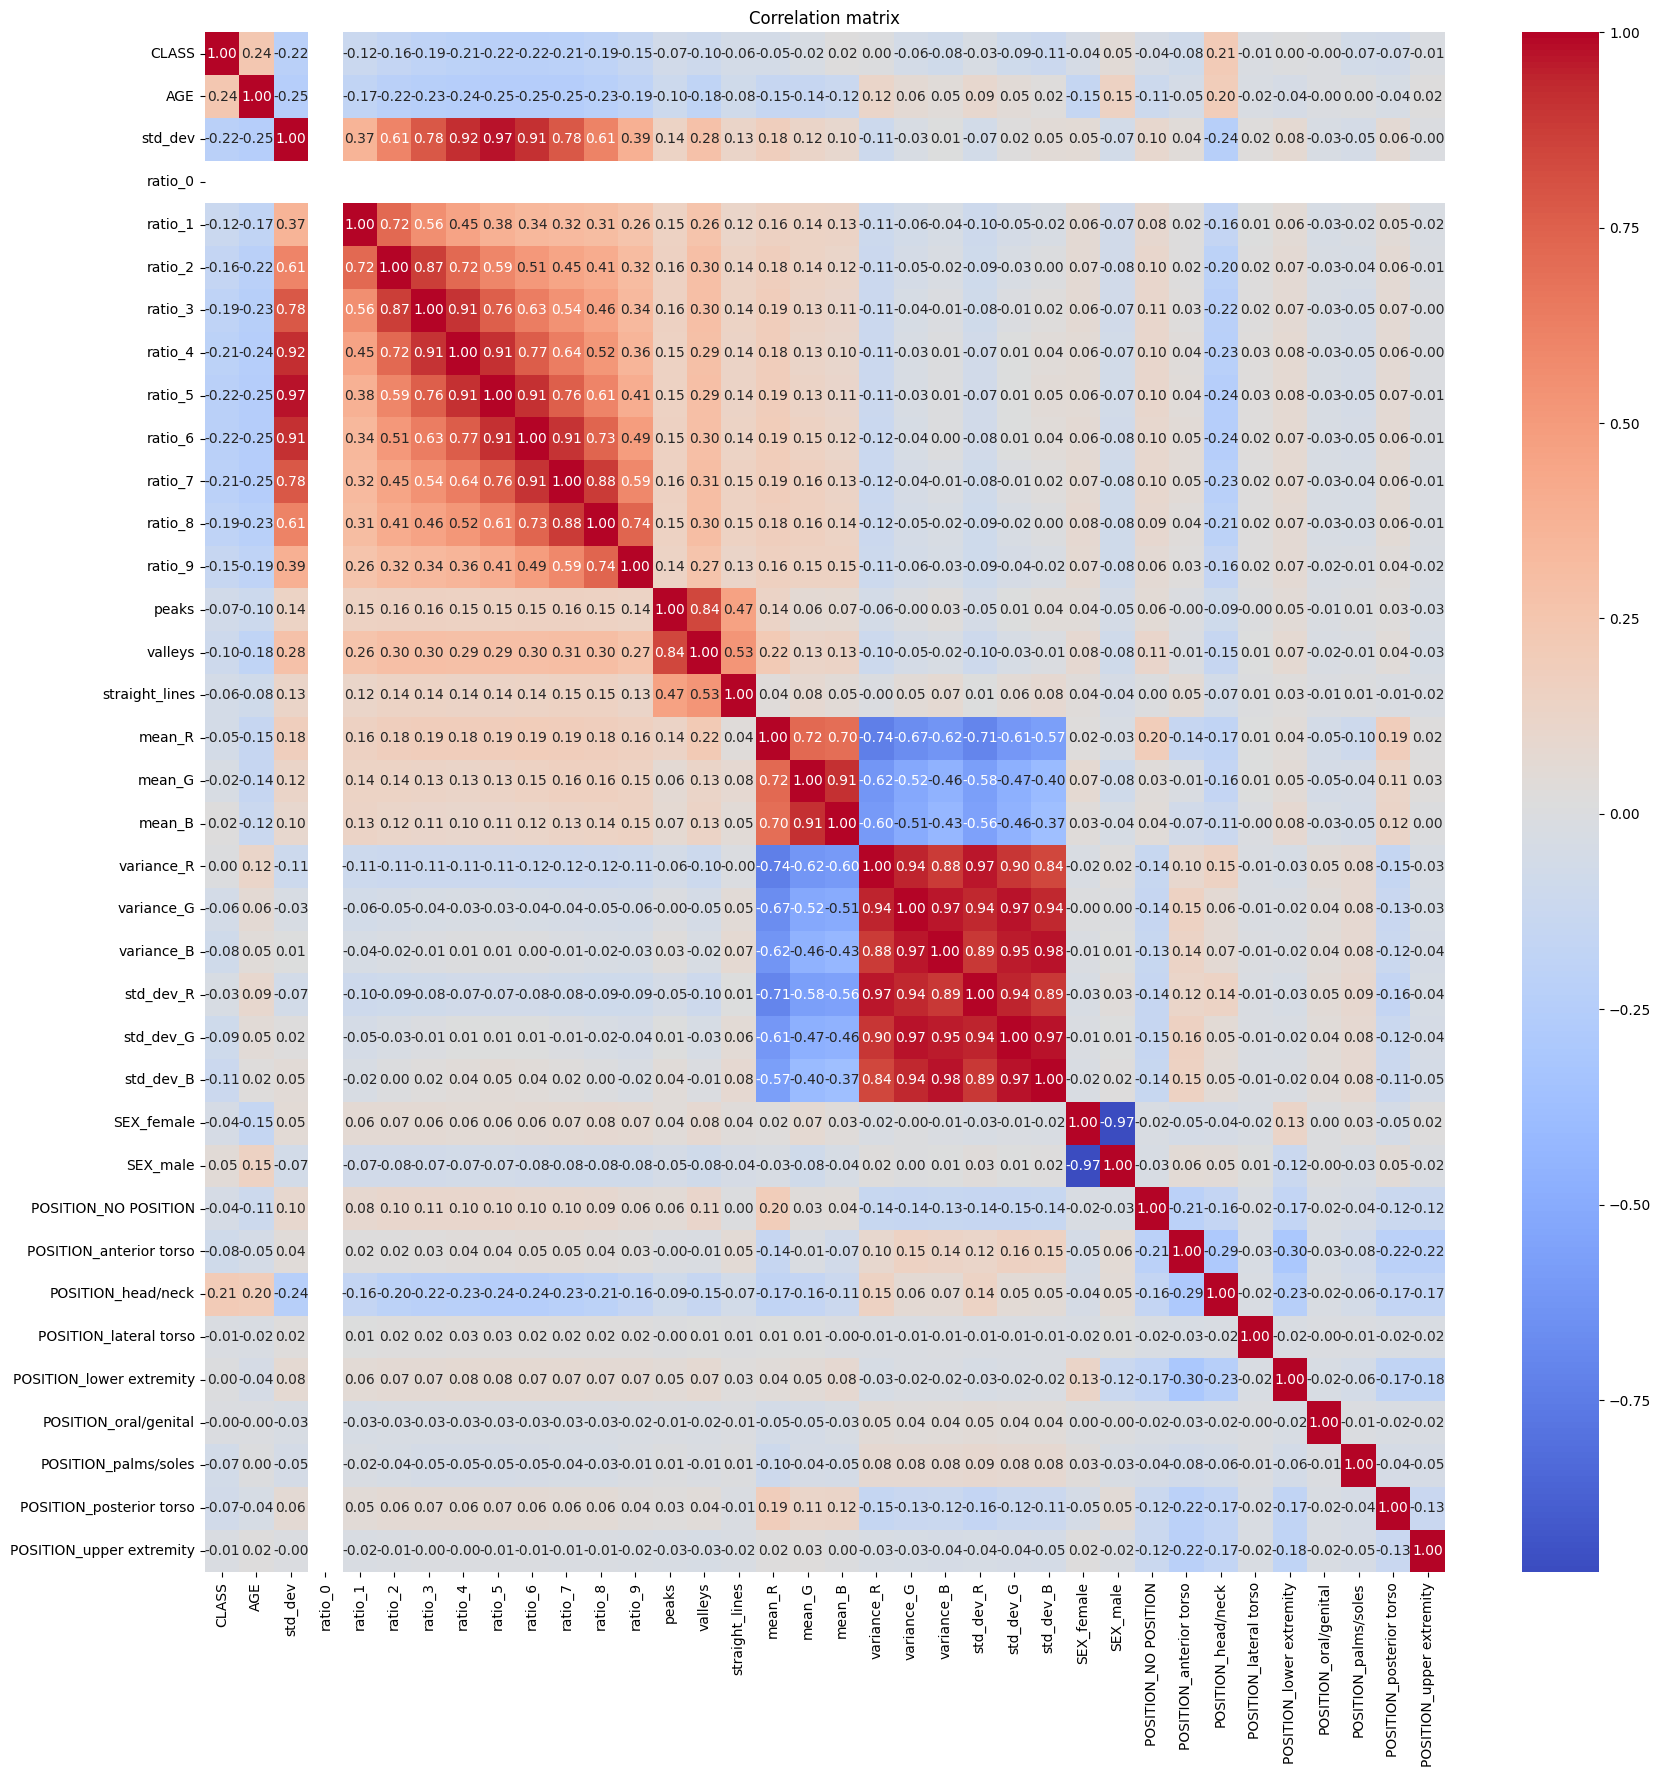

In [ ]:
#Correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(train_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation matrix')
plt.show()

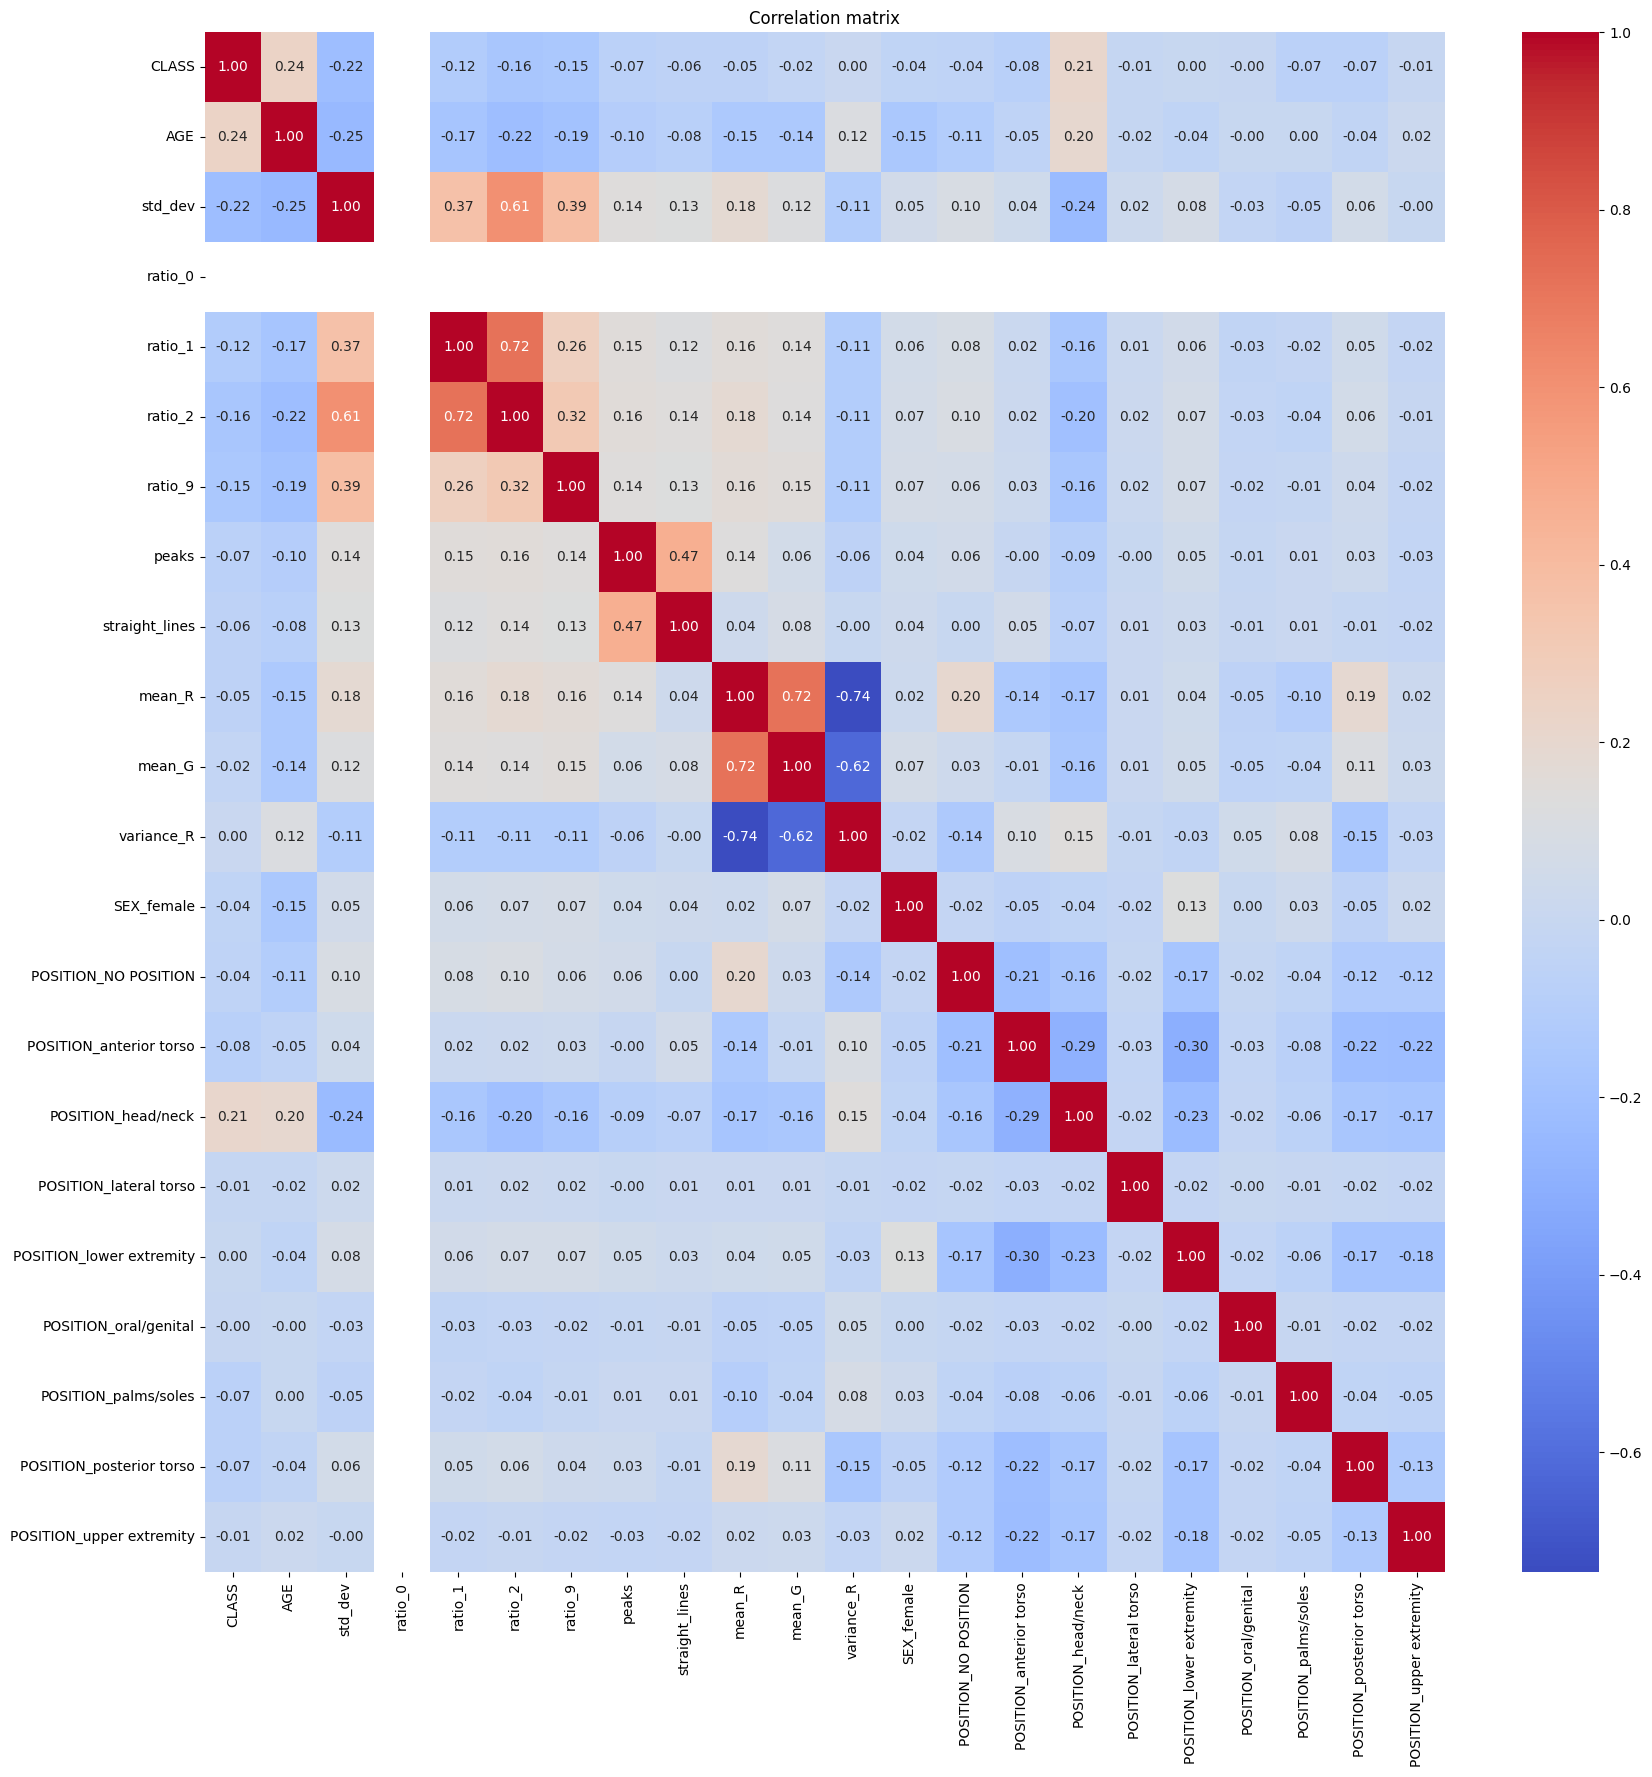

In [ ]:
#Drop the variables with more than 80% of correlation

# Create correlation matrix
corr_matrix = train_data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Find index of feature columns with correlation greater than 0.80
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

# Drop features
train_data = train_data.drop(columns=to_drop)
test_data = test_data.drop(columns=to_drop)

#Correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(train_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation matrix')
plt.show()

#### Data Analysis

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18994 entries, 0 to 18993
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLASS                     18994 non-null  int64  
 1   AGE                       18994 non-null  float64
 2   std_dev                   18994 non-null  float64
 3   ratio_0                   18994 non-null  float64
 4   ratio_1                   18994 non-null  float64
 5   ratio_2                   18994 non-null  float64
 6   ratio_9                   18994 non-null  float64
 7   peaks                     18994 non-null  int64  
 8   straight_lines            18994 non-null  int64  
 9   mean_R                    18994 non-null  float64
 10  mean_G                    18994 non-null  float64
 11  variance_R                18994 non-null  float64
 12  SEX_female                18994 non-null  bool   
 13  POSITION_NO POSITION      18994 non-null  bool   
 14  POSITI

In [ ]:
train_features_df.head()

ID   std_dev  ratio_0   ratio_1   ratio_2   ratio_3   ratio_4  \
0  ISIC_0000000  0.182131      0.0  0.080932  0.180794  0.294502  0.424131   
1  ISIC_0000001  0.176043      0.0  0.037796  0.013801  0.079367  0.254789   
2  ISIC_0000002  0.166796      0.0  0.040916  0.136592  0.280522  0.452188   
3  ISIC_0000003  0.207064      0.0  0.094680  0.204136  0.357426  0.507228   
4  ISIC_0000004  0.144002      0.0  0.097440  0.230866  0.389749  0.381894   

    ratio_5   ratio_6   ratio_7  ...  straight_lines      mean_R      mean_G  \
0  0.573143  0.499234  0.371175  ...               0  130.660648  147.117106   
1  0.440613  0.496273  0.383623  ...               0  165.146776  161.020629   
2  0.522832  0.373599  0.265478  ...               0  134.735257  149.349132   
3  0.660333  0.547944  0.348367  ...              10  189.418496  175.358269   
4  0.302584  0.177002  0.094743  ...               0   89.518051   67.397133   

       mean_B   variance_R   variance_G   variance_B  std_dev_R  std_dev_G  \
0  169.387552  2433.350364  5051.168766  7500.779899  49.329001  71.071575   
1  164.493548   696.571835  1018.004742  1314.743211  26.392647  31.906187   
2  186.187582   858.378118  2036.597010  4374.152700  29.298091  45.128672   
3  167.104875  2012.370222  3766.464073  5284.992808  44.859450  61.371525   
4   79.041519  9168.672252  5770.721633  7612.894685  95.753184  75.965266   

   std_dev_B  
0  86.607043  
1  36.259388  
2  66.137377  
3  72.697956  
4  87.251904  

[5 rows x 24 columns]

In [ ]:
train_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18994 entries, 0 to 18993
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              18994 non-null  object 
 1   std_dev         18994 non-null  float64
 2   ratio_0         18994 non-null  float64
 3   ratio_1         18994 non-null  float64
 4   ratio_2         18994 non-null  float64
 5   ratio_3         18994 non-null  float64
 6   ratio_4         18994 non-null  float64
 7   ratio_5         18994 non-null  float64
 8   ratio_6         18994 non-null  float64
 9   ratio_7         18994 non-null  float64
 10  ratio_8         18994 non-null  float64
 11  ratio_9         18994 non-null  float64
 12  peaks           18994 non-null  int64  
 13  valleys         18994 non-null  int64  
 14  straight_lines  18994 non-null  int64  
 15  mean_R          18994 non-null  float64
 16  mean_G          18994 non-null  float64
 17  mean_B          18994 non-null 

In [5]:
train_data.describe()

CLASS           AGE       std_dev  ratio_0       ratio_1  \
count  18994.00000  18994.000000  18994.000000  18994.0  18994.000000   
mean       2.56839     53.993840      0.127611      0.0      0.062703   
std        1.53287     17.940145      0.056049      0.0      0.028801   
min        1.00000      0.000000      0.011272      0.0      0.000459   
25%        2.00000     40.000000      0.080428      0.0      0.039931   
50%        2.00000     55.000000      0.133179      0.0      0.069524   
75%        3.00000     70.000000      0.172017      0.0      0.087571   
max        8.00000     85.000000      0.295805      0.0      0.111111   

            ratio_2       ratio_9         peaks  straight_lines        mean_R  \
count  18994.000000  18994.000000  18994.000000    18994.000000  18994.000000   
mean       0.129266      0.062755      8.258187        0.389807    168.912900   
std        0.068383      0.029152     25.095582        1.838614     38.230022   
min        0.000000      0.000000      0.000000        0.000000     31.422775   
25%        0.069813      0.039147      0.000000        0.000000    151.205948   
50%        0.138511      0.069518      0.000000        0.000000    172.771647   
75%        0.189745      0.088499      0.000000        0.000000    194.740304   
max        0.250000      0.111111    266.000000       46.000000    252.695867   

             mean_G    variance_R  
count  18994.000000  18994.000000  
mean     133.826720   1766.881407  
std       29.519938   2438.382355  
min       31.409744      5.427547  
25%      118.355071    253.134743  
50%      136.297997    658.213977  
75%      153.538485   2043.828861  
max      234.843469  12396.461206

In [ ]:
#Plot the histogram distribution of every variable
train_data.hist(figsize=(20, 20))
plt.show()

In [ ]:
#SAVE THE DATA IN CSV
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

# Classification

In [69]:
#UPLOAD THE DATA FROM CSV
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [70]:
###### BORRAR CELDA ###########

# Load the data
train_metadata = pd.read_csv('metadataTrain.csv')
test_metadata = pd.read_csv('metadataTest.csv')

train_data = train_metadata
test_data = test_metadata

#Fill null age with mean
train_data['AGE'] = train_data['AGE'].fillna(train_data['AGE'].mean())
test_data['AGE'] = test_data['AGE'].fillna(test_data['AGE'].mean())


#Fill null POSITION with NO POSTION
imputer = SimpleImputer(strategy='most_frequent')
train_data['POSITION'] = pd.DataFrame(imputer.fit_transform(train_data[['POSITION']]))
train_data['SEX'] = pd.DataFrame(imputer.fit_transform(train_data[['SEX']]))
                                          
imputer = SimpleImputer(strategy='most_frequent')                                          
test_data['POSITION'] = pd.DataFrame(imputer.fit_transform(test_data[['POSITION']]))
test_data['SEX'] = pd.DataFrame(imputer.fit_transform(test_data[['SEX']]))

#One hot encoding SEX and POSITION
train_data = pd.get_dummies(train_data, columns=['SEX','POSITION'])
test_data = pd.get_dummies(test_data, columns=['SEX','POSITION'])

#Drop the ID column
train_data = train_data.drop(columns='ID')

In [71]:
#Split the data
X_train, X_test, y_train, y_test = train_test_split(train_data.drop(columns='CLASS'), train_data['CLASS'], test_size=0.000001, random_state=42)

# X_train = train_data.drop(columns='CLASS')
# y_train = train_data['CLASS']

# X_test = test_data

#Normalize and scale data
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [72]:
#Custom Scorer for the weighted accuracy
weights = {
     1:0.7005531, 
     2:0.24592265, 
     3:0.95261733, 
     4:3.64804147, 
     5:1.20674543,
     6: 13.19375,
     7: 12.56547619,
     8: 5.04219745
     }
     
def weighted_accuracy(y_true, y_pred):
    
    N = len(y_true)
    wa_sum = 0
    for i in range(N):
        if y_true.iloc[i] == y_pred[i]:
            wa_sum += weights[y_true.iloc[i]]
    return wa_sum / N


### Random Forest

In [74]:
#Random Forest

#Grid search
model_rf = RandomForestClassifier( class_weight=weights)
#param_grid = {'n_estimators': [10, 100, 1000], 'max_features': ['sqrt', 'log2']}

param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum number of levels in each decision tree
    'min_samples_split': [2, 5, 10],  # Minimum number of data points placed in a node before the node is split
    'min_samples_leaf': [1, 2, 4]  # Minimum number of data points allowed in a leaf node
}

grid_rf = GridSearchCV(model_rf, param_grid, refit=True, verbose=3, scoring=make_scorer(weighted_accuracy, greater_is_better=True))
grid_rf.fit(X_train, y_train)

print(grid_rf.best_params_)
print(grid_rf.best_estimator_)

best_model_rf = grid_rf.best_estimator_

#Predictions
grid_predictions_rf = best_model_rf.predict(X_test)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.346 total time=   0.5s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.341 total time=   0.5s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.295 total time=   0.5s
[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.384 total time=   0.5s
[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.335 total time=   0.5s
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.339 total time=   1.0s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.337 total time=   1.0s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.307 total time=   1.0s
[CV 4/5] END max_depth=None, min_samples

In [75]:
#Print the classification report
print(classification_report(y_test, grid_predictions_rf))

#Print weighted accuracy
print(f'Weighted accuracy: {weighted_accuracy(y_test, grid_predictions_rf)}')


              precision    recall  f1-score   support

           2       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

Weighted accuracy: 0.24592265


In [76]:
#SVM
SVM = SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=weights)

#Grid search
param_grid = {
    'kernel' : ['linear', 'rbf'],
    'C' : [0.5, 1, 4, 8, 16, 32, 64, 128]
}

grid_svm = GridSearchCV(SVM, param_grid, refit=True, verbose=3, scoring=make_scorer(weighted_accuracy))
grid_svm.fit(X_train, y_train)

print(grid_svm.best_params_)
print(grid_svm.best_estimator_)

best_model_svm = grid_svm.best_estimator_

#Predictions
grid_predictions_svm = best_model_svm.predict(X_test)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[CV 1/5] END ..............C=0.5, kernel=linear;, score=0.294 total time=  13.5s
[CV 2/5] END ..............C=0.5, kernel=linear;, score=0.302 total time=  13.4s
[CV 3/5] END ..............C=0.5, kernel=linear;, score=0.321 total time=  13.4s
[CV 4/5] END ..............C=0.5, kernel=linear;, score=0.330 total time=  13.2s
[CV 5/5] END ..............C=0.5, kernel=linear;, score=0.313 total time=  13.2s
[CV 1/5] END .................C=0.5, kernel=rbf;, score=0.304 total time=  19.4s
[CV 2/5] END .................C=0.5, kernel=rbf;, score=0.306 total time=  19.3s
[CV 3/5] END .................C=0.5, kernel=rbf;, score=0.306 total time=  19.4s
[CV 4/5] END .................C=0.5, kernel=rbf;, score=0.327 total time=  19.3s
[CV 5/5] END .................C=0.5, kernel=rbf;, score=0.309 total time=  19.0s
[CV 1/5] END ................C=1, kernel=linear;, score=0.295 total time=  13.5s
[CV 2/5] END ................C=1, kernel=linear;, score=0.301 total time=  13.5s
[CV 3/5] END ...............

KeyboardInterrupt: 

In [ ]:
#Print the classification report
print(classification_report(y_test, grid_predictions_svm))

#Print weighted accuracy
print(f'Weighted accuracy: {weighted_accuracy(y_test, grid_predictions_svm)}')

              precision    recall  f1-score   support

           1       0.26      0.09      0.14       670
           2       0.79      0.48      0.60      1908
           3       0.28      0.18      0.22       513
           4       0.15      0.66      0.24       135
           5       0.17      0.07      0.09       398
           6       0.03      0.70      0.07        37
           7       0.03      0.16      0.05        45
           8       0.08      0.27      0.12        94

    accuracy                           0.33      3800
   macro avg       0.22      0.33      0.19      3800
weighted avg       0.50      0.33      0.38      3800

Weighted accuracy: 0.3342480601710542


In [ ]:
#Logistic Regression

#Grid search
model = LogisticRegression( class_weight=weights)
#param_grid = {'C': [0.1, 1, 10, 100]}
param_grid = {'C': [0.1, 1]}
grid_lr = GridSearchCV(model, param_grid, refit=True, verbose=3, scoring=make_scorer(weighted_accuracy))
grid_lr.fit(X_train, y_train)

print(grid_lr.best_params_)
print(grid_lr.best_estimator_)

best_model_lr = grid_lr.best_estimator_

#Predictions
grid_predictions_lr = best_model_lr.predict(X_test)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[CV 1/5] END .............................C=0.1;, score=0.307 total time=   1.1s
[CV 2/5] END .............................C=0.1;, score=0.311 total time=   0.6s
[CV 3/5] END .............................C=0.1;, score=0.323 total time=   0.7s
[CV 4/5] END .............................C=0.1;, score=0.343 total time=   0.8s
[CV 5/5] END .............................C=0.1;, score=0.317 total time=   0.7s


/home/infres/jrios-23/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ...............................C=1;, score=0.303 total time=   0.9s


/home/infres/jrios-23/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ...............................C=1;, score=0.302 total time=   1.0s


/home/infres/jrios-23/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ...............................C=1;, score=0.315 total time=   1.0s


/home/infres/jrios-23/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ...............................C=1;, score=0.346 total time=   0.8s


/home/infres/jrios-23/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ...............................C=1;, score=0.323 total time=   0.7s
{'C': 0.1}
LogisticRegression(C=0.1,
                   class_weight={1: 0.7005531, 2: 0.24592265, 3: 0.95261733,
                                 4: 3.64804147, 5: 1.20674543, 6: 13.19375,
                                 7: 12.56547619, 8: 5.04219745})


In [ ]:
#Print the classification report
print(classification_report(y_test, grid_predictions_lr))

#Print weighted accuracy
print(f'Weighted accuracy: {weighted_accuracy(y_test, grid_predictions_lr)}')

              precision    recall  f1-score   support

           1       0.40      0.08      0.13       670
           2       0.80      0.44      0.57      1908
           3       0.24      0.24      0.24       513
           4       0.14      0.67      0.24       135
           5       0.16      0.03      0.05       398
           6       0.03      0.70      0.06        37
           7       0.01      0.07      0.02        45
           8       0.08      0.27      0.13        94

    accuracy                           0.31      3800
   macro avg       0.23      0.31      0.18      3800
weighted avg       0.53      0.31      0.36      3800

Weighted accuracy: 0.31882498307894874


# Metrics
As ranking metric, we will use the Weighted Categorization Accuracy which is defined as:
$$WA=1N∑i=1NwiI(yi=fi)$$
such that
$$∑i=1Nwi=N$$
in order to keep the maximum value equal to 1

where $y_i$ are ground truths, $f_i$ are the predicted results, and $w_i$ are the weights of the $i-th$ test image. If we make the hypothesis that we have $K$ groups - or classes - called $G={G_1,…,G_K}$ and we associate the same weight $w_t$ to all images of the same group $t$, we obtain that the weights are equal to: $w_t = \frac{ N }{ k |G_t|}$

In this way, we can take into account the imbalance nature of the data-set, if present.
Please note that the class weights in the test set are equal to: [ 0.7005531 0.24592265 0.95261733 3.64804147 1.20674543 13.19375 12.56547619 5.04219745]

In [ ]:
#Calculate the weighted accuracy for every prediction to get the best model
#$$WA=1N∑i=1NwiI(yi=fi)$$

# #SVM
# print(classification_report(y_test, grid_predictions_svm))
# print(confusion_matrix(y_test, grid_predictions_svm))
print('SVM')
print(weighted_accuracy(y_test, grid_predictions_svm))

# #Random Forest
# print(classification_report(y_test, grid_predictions_rf))
# print(confusion_matrix(y_test, grid_predictions_rf))
print('Random Forest')
print(weighted_accuracy(y_test, grid_predictions_rf))

# #Logistic Regression
# print(classification_report(y_test, grid_predictions_lr))
# print(confusion_matrix(y_test, grid_predictions_lr))
print('Logistic Regression')
print(weighted_accuracy(y_test, grid_predictions_lr))

# #KNN
# print(classification_report(y_test, grid_predictions_knn))
# print(confusion_matrix(y_test, grid_predictions_knn))
# print(weighted_accuracy(y_test, grid_predictions_knn))


#Select the best model
#The best model is the one with the highest weighted accuracy


models_results = [best_model_svm, best_model_rf, best_model_lr]
results = [grid_predictions_svm, grid_predictions_rf, grid_predictions_lr]

best_results = results[np.argmax([weighted_accuracy(y_test, model) for model in results])]
best_model = models_results[np.argmax([weighted_accuracy(y_test, model) for model in results])]

print("\n BEST MODEL : ")
print(best_model)

#predictions for test_data
test_predictions = best_model.predict(test_data.drop(columns='ID'))

#Now I need to put every prediction to the according ID that has in the test data
test_predictions = pd.DataFrame(test_predictions, columns=['CLASS'])
test_predictions = pd.concat([test_data['ID'], test_predictions], axis=1)

#save the predictions
pd.DataFrame(test_predictions, columns=['ID','CLASS']).to_csv('submission.csv', index=False)


SVM
0.3342480601710542
Random Forest
0.3578306961552644
Logistic Regression
0.31882498307894874

 BEST MODEL : 
RandomForestClassifier(class_weight={1: 0.7005531, 2: 0.24592265, 3: 0.95261733,
                                     4: 3.64804147, 5: 1.20674543, 6: 13.19375,
                                     7: 12.56547619, 8: 5.04219745},
                       max_depth=10, min_samples_split=10)


/home/infres/jrios-23/.local/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [77]:
best_model = best_model_rf

print("\n BEST MODEL : ")
print(best_model)

#predictions for test_data
test_predictions = best_model.predict(test_data.drop(columns='ID'))

#Now I need to put every prediction to the according ID that has in the test data
test_predictions = pd.DataFrame(test_predictions, columns=['CLASS'])
test_predictions = pd.concat([test_data['ID'], test_predictions], axis=1)

#save the predictions
pd.DataFrame(test_predictions, columns=['ID','CLASS']).to_csv('submission.csv', index=False)


 BEST MODEL : 
RandomForestClassifier(class_weight={1: 0.7005531, 2: 0.24592265, 3: 0.95261733,
                                     4: 3.64804147, 5: 1.20674543, 6: 13.19375,
                                     7: 12.56547619, 8: 5.04219745},
                       max_depth=10, min_samples_leaf=4, min_samples_split=10)


/home/infres/jrios-23/.local/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


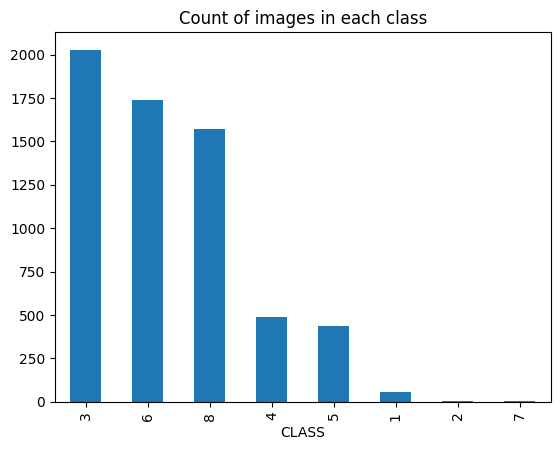

In [78]:
#Plot test predictions hist of classes
# Value counts of the classes
test_predictions['CLASS'].value_counts().plot(kind='bar')
plt.title('Count of images in each class')
plt.show()


# Convolutional Neural Networks

In [108]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Dense, Activation
from keras.layers import Dense, Dropout
import keras.backend as K

In [109]:
metadata_train = pd.read_csv('metadataTrain.csv')     
metadata_test = pd.read_csv('metadataTest.csv')

train_labels = metadata_train["CLASS"].values

train_images = os.listdir('Train/Train')
train_images = [image for image in train_images if image.endswith('.jpg')]


train_df = pd.DataFrame()
train_df["Path"] = train_images
train_df["Label"] = train_labels.astype(str)

In [110]:
split = 0.2

train_datagen = ImageDataGenerator(     rescale = 1./255,
                                        validation_split = 0.2,
                                        rotation_range=5,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='nearest',
                                )

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [113]:
train_dataset  = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = './Train/Train',
    x_col = "Path",
    y_col = "Label",
    subset="training",
    target_size = (224,224),
    class_mode = 'categorical',
    batch_size = 32
    )

valid_dataset = valid_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = './Train/Train',
    x_col = "Path",
    y_col = "Label",
    subset="validation",
    target_size = (224,224),
    class_mode = 'categorical',
    batch_size = 32
    )

# test_dataset = test_datagen.flow_from_directory(directory = './Test',
#                                                   target_size = (224,224),
#                                                   class_mode = 'categorical',
#                                                   batch_size = 32)

Found 15199 validated image filenames belonging to 8 classes.
Found 3799 validated image filenames belonging to 8 classes.


In [114]:
base_model =tf.keras.applications.ResNet101(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

for layer in base_model.layers:
    layer.trainable=False


In [115]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(8,activation='softmax'))

In [116]:
# Model Summary

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 batch_normalization_6 (Bat  (None, 100352)            401408    
 chNormalization)                                                
                                                                 
 dense_45 (Dense)            (None, 64)                6422592   
                                                                 
 batch_normalization_7 (Bat  (None, 64)                256       
 chNormalization)                                    

In [133]:
weights_nn = {
     1:0.7005531, 
     2:0.24592265, 
     3:0.95261733, 
     4:3.64804147, 
     5:1.20674543,
     6: 13.19375,
     7: 12.56547619,
     8: 5.04219745
     }

def weighted_accuracy_NN(y_true, y_pred):
     N = len(y_true)

     y_pred = K.cast(K.argmax(y_pred), dtype='int64')
     y_true = K.cast(y_true, dtype='int64')

     wa_sum = 0
     for i in range(N):
          if y_true[i].ref() == y_pred[i].ref():
               wa_sum += weights_nn[y_true[i].ref()]
     return wa_sum / N

In [134]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 5) # when i run it for 50 epochs

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [135]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy',weighted_accuracy_NN])

In [136]:
history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 20,
                        verbose = 1,
                         callbacks=lr_scheduler)

Epoch 1/20


2024-04-23 17:57:40.083083: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


475/475 [==============================] - 170s 336ms/step - loss: 1.4972 - accuracy: 0.5006 - weighted_accuracy_NN: 0.0000e+00 - val_loss: 1.4627 - val_accuracy: 0.5093 - val_weighted_accuracy_NN: 0.0000e+00 - lr: 0.0100
Epoch 2/20
325/475 [===================>..........] - ETA: 44s - loss: 1.4693 - accuracy: 0.5066 - weighted_accuracy_NN: 0.0000e+00

In [ ]:
scores = model.evaluate(valid_dataset, verbose=1)

In [ ]:
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Test weighted accuracy:', scores[2])

# Convolutional NN

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import time
import os
import copy

In [19]:
class CustomDataset(Dataset):
    def __init__(self, paths, labels, folder : str, transform):
        """
            paths : list of paths to the images
            labels : list of the labels (between 1 and 8)
            folder : folder containing the data
            transform : the transformation to apply
        """
        self.paths = paths
        self.labels = labels  
        self.transform = transform
        self.folder = folder
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        # choose the file
        file = self.paths[idx]
        label = self.labels[idx]-1 # as the label provided are between 1 and 8 (included)
        # open the file
        inp = Image.open(os.path.join(self.folder,file+".jpg"))
        # Apply transformation
        if self.transform :
            inp = self.transform(inp)
                
        return inp, label


In [25]:
learning_rate = 0.01
num_epochs = 3
batch_size = 32
resize_shape = (28, 28)
num_classes = 8
feature_extract = True 

batch_size = 8

split = 0.2

In [26]:
df = pd.read_csv("metadataTrain.csv")
paths = list(df["ID"])
labels = list(df["CLASS"])
val_size = int(0.8*len(paths))

X_train, y_train, X_val, y_val = paths[:val_size], labels[:val_size], paths[val_size:], labels[val_size:]


img_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(X_train, y_train, './Train/Train', transform=img_transform)
val_dataset = CustomDataset(X_val, y_val, './Train/Train', transform=img_transform)


image_datasets = {'train':train_dataset, 'val':val_dataset}
dataloaders_dict = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

In [27]:
# Feature extracting = True -> requires_grad = False
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model = None
    input_size = 0
    
    model = models.resnet101(pretrained=use_pretrained)
    set_parameter_requires_grad(model, feature_extract)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    input_size = 224
    
    return model

In [28]:
model = initialize_model(num_classes, feature_extract)

model = model.to(device)

params_to_update = model.parameters()
if feature_extract:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print(name)
else:
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name)

# The parameters are optimizing
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Loss function
criterion = nn.CrossEntropyLoss()

/home/infres/jrios-23/miniconda3/envs/venv_cuda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/infres/jrios-23/miniconda3/envs/venv_cuda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


fc.weight
fc.bias


In [29]:
def train_model(model, dataloaders, optimizer, criterion=criterion, num_epochs=num_epochs, is_inception=False):
    start = time.time()
    val_acc_history = []
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)
        
        # Each epoch's training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # Do this if model is in training phase
            else:
                model.eval()    # Do this if model is in validation phase
                
            running_loss = 0
            running_corrects = 0
            
            # Iteration over the data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Parameter gradients are initialized to 0
                optimizer.zero_grad()
                
                # Forward Pass
                # Getting model outputs and calculating loss
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':      # Special case of inception because InceptionV3 has auxillary outputs as well. 
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        
                    _, preds = torch.max(outputs, 1)
                    
                    # Backward pass and Optimization in training phase 
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Stats
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                
    time_elapsed = time.time()
    
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # Best model weights are loaded here
    model.load_state_dict(best_model_weights)
    return model, val_acc_history


model, history = train_model(model, dataloaders_dict, optimizer, criterion, num_epochs, False)



Epoch 0/2
----------


In [ ]:
model.save('model.h5')

# Conclusions

# References


* http://ieeexplore.ieee.org/document/918473/
* https://www.sciencedirect.com/science/article/pii/S0933365712001108#bib0180
* https://www.sciencedirect.com/science/article/pii/S0957417416302354#bib0023
* https://www.sciencedirect.com/science/article/pii/S0933365713001589
* https://www.nature.com/articles/nature21056
* https://hal-univ-bourgogne.archives-ouvertes.fr/hal-01250955/document
* https://workshop2021.isic-archive.com/
* https://workshop2020.isic-archive.com/#paper